In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.special import j1
from scipy.optimize import curve_fit

def airy_profile(r, alpha, C):
    # avoid division by zero at r=0
    x = alpha * r
    # use Taylor limit at x=0: [2J1(x)/x]^2 → 1
    val = np.ones_like(r)
    nonzero = x != 0
    val[nonzero] = (2 * j1(x[nonzero]) / x[nonzero])**2
    return  val + C

@njit
def compute_radial_profile(I_norm, cx, cy, radius_int, bin_width_px):
    h = I_norm.shape[0]
    w = I_norm.shape[1]
    max_r_px = radius_int
    nbins = int(np.ceil(max_r_px / bin_width_px))

    bin_sums = np.zeros(nbins)
    bin_counts = np.zeros(nbins)

    for y in range(h):
        for x in range(w):
            r = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
            if r < max_r_px:
                bin_idx = int(r // bin_width_px)
                if bin_idx < nbins:  
                    bin_sums[bin_idx] += I_norm[y, x]
                    bin_counts[bin_idx] += 1

    radial_mean = np.empty(nbins)
    for i in range(nbins):
        if bin_counts[i] > 0:
            radial_mean[i] = bin_sums[i] / bin_counts[i]
        else:
            radial_mean[i] = np.nan

    return radial_mean

def calc_radial_profile(gray, cx, cy, radius_int, pixel_to_mm, bin_width_px=1):
    if gray.ndim == 3:
        gray = gray.mean(axis=2)  # Convert RGB to grayscale if needed

    # Normalize image
    I_norm = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))

    # Compute radial profile using numba
    I_r = compute_radial_profile(I_norm, cx, cy, radius_int, bin_width_px)
        
    # Prepare radius in mm
    nbins = len(I_r)
    r_px = (np.arange(nbins) + 0.5) * bin_width_px
    r_mm = r_px * pixel_to_mm
    
    # Renormalize
    I_r = I_r - I_r.min()
    I_r = I_r/I_r.max()
    # Plot
    

    return I_r, r_mm

def plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, plot_title):
    plt.figure(figsize=(6, 4))
    plt.plot(r_data, I_data, '-o', markersize=3, label = "Data")

#     a = D / 2    
#     k = 2 * np.pi / wavelength
#     z =  1.356 
#     r_lin = np.linspace(0, max(r_data), len(r_data))
#     krz_lin = k * a * r_lin / z
#     ampl_lin = np.ones_like(r_lin)
#     nonzero_lin = krz_lin != 0
#     ampl_lin[nonzero_lin] = 2 * j1(krz_lin[nonzero_lin]) / krz_lin[nonzero_lin]
#     int_lin = ampl_lin**2
#     int_lin /= int_lin.max()

    plt.plot(r_data, I_fit, '-x',markersize = 1, label = "Curve Fit")
    plt.plot(r_data, I_theo, '-x',markersize = 1, label = "Expected")
    
    plt.xlabel('Radius (mm)')
    plt.ylabel('Normalized Intensity')
    plt.title('Poisson Spot Radial Profile')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{plot_title}.pdf")    
#     plt.semilogy()
    plt.show()

def plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, plot_title2):
    z =  1.356
    a = radius_int*pixel_to_mm
    theta = np.linspace(0, 2*np.pi, 1000)
    xc = a * np.cos(theta)
    yc = a * np.sin(theta)

    # === Generate 2D grid ===
    x = np.linspace(-max(r_data), max(r_data), len(r_data))
    X, Y = np.meshgrid(x, x)
    r = np.sqrt(X**2 + Y**2)

    # === Compute far-field diffraction amplitude and intensity (Airy pattern from complementary aperture) ===
    k = 2 * np.pi / wavelength
    krz = k * a*1e-3 * r / z
    amplitude = np.ones_like(r)
    nonzero = krz != 0
    amplitude[nonzero] = 2 * j1(krz[nonzero]) / krz[nonzero]
    intensity = amplitude**2

    # Normalize
    intensity /= intensity.max()

    # === Plot 1: 2D intensity map ===
    plt.figure()
    plt.imshow(intensity, extent=(-2*max(r_data) - 0.5, 2*max(r_data) + 0.5, -2*max(r_data) - 0.5, 2*max(r_data) + 0.5))
    plt.plot(xc, yc, 'r-', linewidth=1.5, label='Disk edge')
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title('Simulated Poisson Spot Intensity')
    plt.colorbar(label='Normalized Intensity')
    plt.tight_layout()
    plt.savefig(f"{plot_title2}.pdf")
    plt.show()


In [2]:
# Data
data_alpha = {}
expected_alpha = {}

## Green Laser

In [3]:
wavelength = 532e-9
z =  1.356 

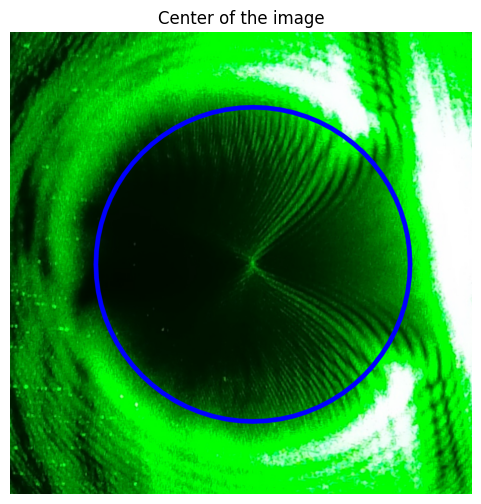

In [4]:
image_path = 'Plots and Data/B2_Files/Green/1.png'
sphere_diameter_mm = 4.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = img.copy()
cx = 2554.7 + 75
cy = 2634.0 - 120

center_int = (int(cx), int(cy))
radius_int = 1700
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (255, 0, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  # red circle

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Green_{sphere_diameter_mm}.pdf")
plt.show()

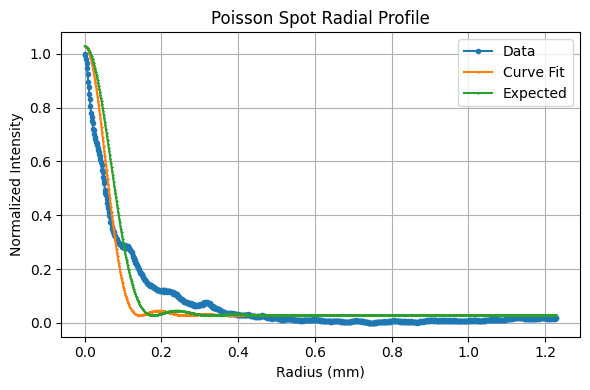

21.426125956015287 26.737064589259944 0.02795860027399334 24.787209055651218


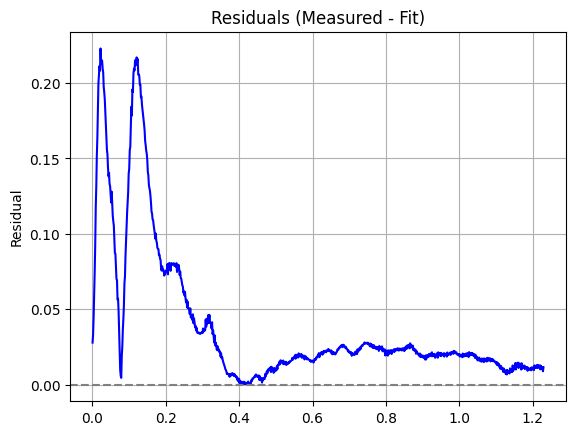

In [5]:
D = 4.92e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)


# Residuals and relative error
residuals = np.abs(I_data - I_fit)
# relative_error = np.abs(residuals / I_fit)

plt.plot(r_data, residuals, 'b-')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Residual')
plt.title('Residuals (Measured - Fit)')
plt.grid(True)
plt.show()


# # Relative error plot
# plt.plot(r_data, 100 * relative_error, 'g-')
# plt.xlabel('Radius (mm)')
# plt.ylabel('Relative Error (%)')
# plt.title('Relative Error vs Radius')
# plt.grid(True)
# plt.show()


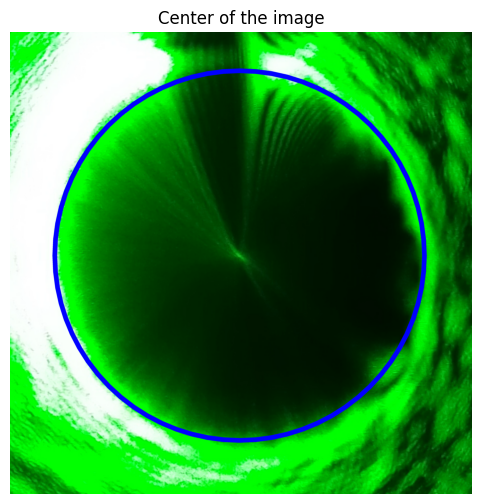

In [6]:
image_path = 'Plots and Data/B2_Files/Green/2.png'
sphere_diameter_mm = 7.05                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = img.copy()
cx = 2554.7 - 70
cy = 2634.0 - 215

center_int = (int(cx), int(cy))
radius_int = 2000
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (255, 0, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  # red circle

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Green_{sphere_diameter_mm}.pdf")
plt.show()

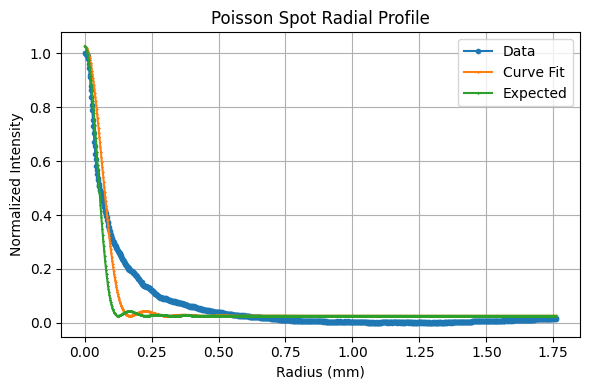

30.70207072965605 22.76025835830925 0.026194813034877373 25.867350906971772


In [7]:
D = 7.05e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)

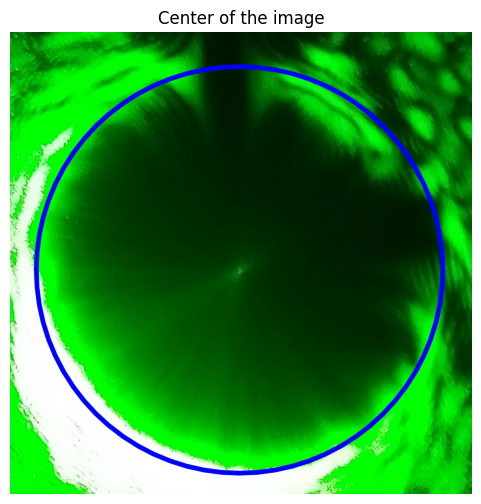

In [8]:
image_path = 'Plots and Data/B2_Files/Green/3.png'
sphere_diameter_mm = 7.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = img.copy()
cx = 2554.7 - 70
cy = 2634.0 - 60

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (255, 0, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  # red circle

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Green_{sphere_diameter_mm}.pdf")
plt.show()

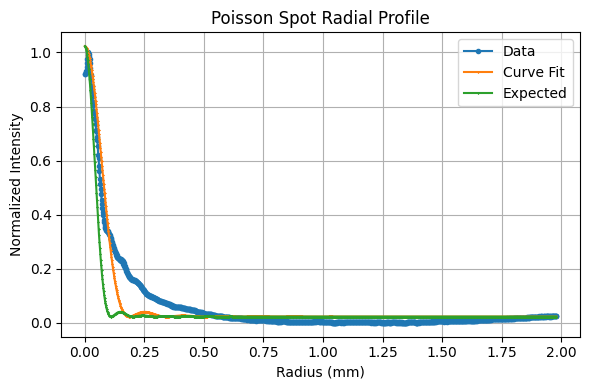

34.49083690480509 20.46059154122842 0.02335509988379841 40.67818186697014


In [9]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)

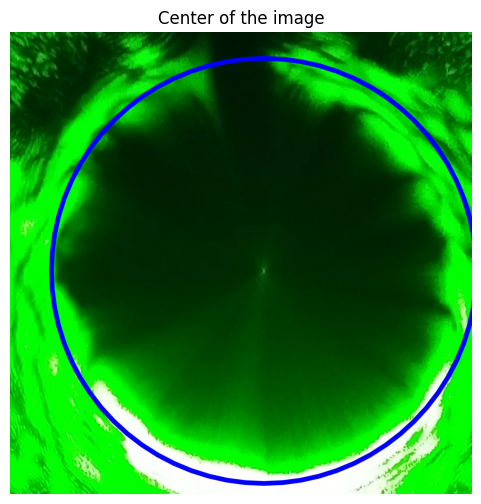

In [10]:
image_path = 'Plots and Data/B2_Files/Green/4.png'
sphere_diameter_mm = 8.95                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = img.copy()
cx = 2554.7 + 194
cy = 2634.0 - 49

center_int = (int(cx), int(cy))
radius_int = 2300
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (255, 0, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  # red circle

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Green_{sphere_diameter_mm}.pdf")
plt.show()

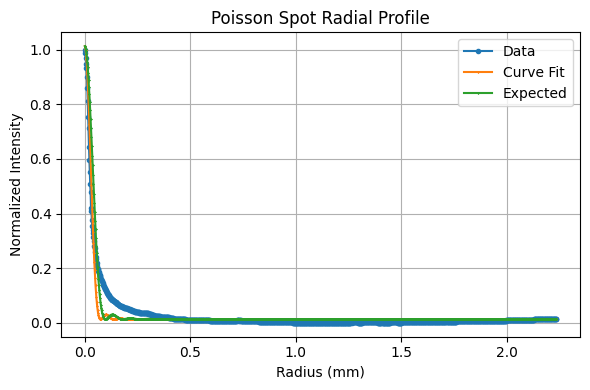

38.9763876638896 50.96733873016898 0.013291823339480148 30.7646546665191


In [11]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)

## Red Laser

In [12]:
wavelength = 650e-9
z =  1.356 

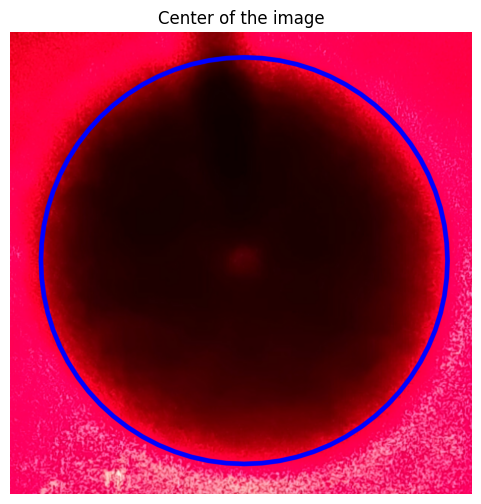

In [13]:
image_path = 'Plots and Data/B2_Files/Red/5.png'
sphere_diameter_mm = 4.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 - 20
cy = 2634.0 - 160

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Red_{sphere_diameter_mm}.pdf")
plt.show()

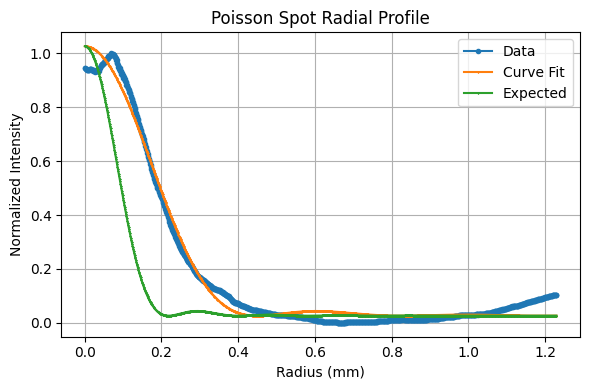

17.536460013230975 8.507473855541864 0.026651068686194265 51.48693722037907


In [14]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)

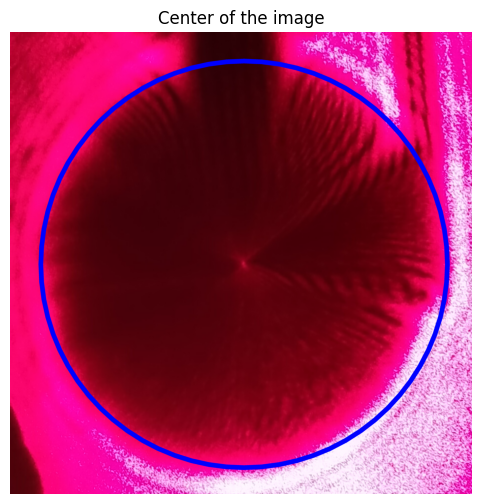

In [15]:
image_path = 'Plots and Data/B2_Files/Red/6.png'
sphere_diameter_mm = 7.05                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 - 21
cy = 2634.0 - 120

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Red_{sphere_diameter_mm}.pdf")
plt.show()

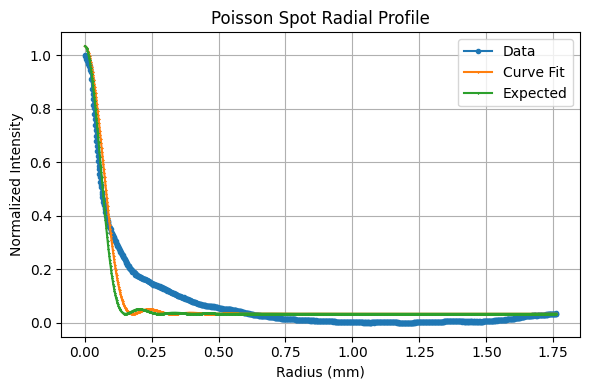

25.12846404334926 21.3780855084847 0.033984812483740634 14.924822020139246


In [16]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)

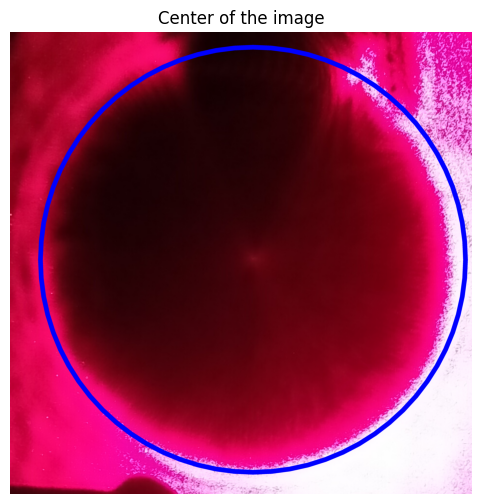

In [17]:
image_path = 'Plots and Data/B2_Files/Red/7.png'
sphere_diameter_mm = 7.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 + 75
cy = 2634.0 - 170

center_int = (int(cx), int(cy))
radius_int = 2300
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Red_{sphere_diameter_mm}.pdf")
plt.show()

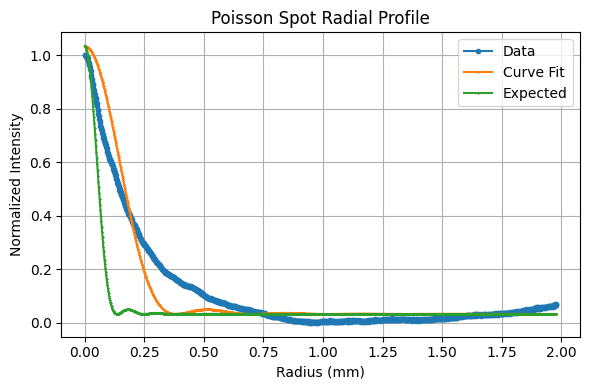

28.22942343593279 10.004140720547191 0.0330867700261127 64.56129986766545


In [18]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)

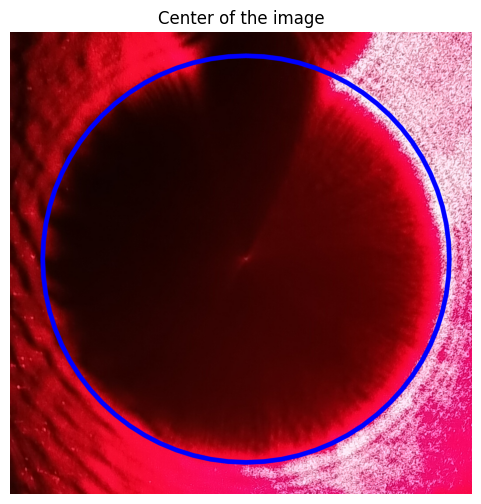

In [19]:
image_path = 'Plots and Data/B2_Files/Red/8.png'
sphere_diameter_mm = 8.95                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 
cy = 2634.0 - 177

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 50, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (0, 0, 255), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Red_{sphere_diameter_mm}.pdf")
plt.show()

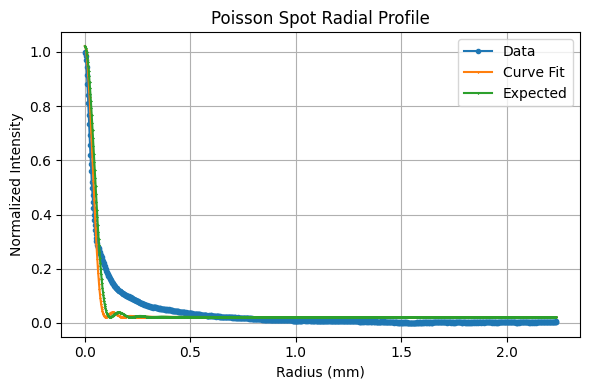

31.900674211060416 38.69451240975484 0.02150903529276399 21.296848316575414


In [20]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)

## Violet

In [21]:
wavelength = 405e-9
z =  1.356 

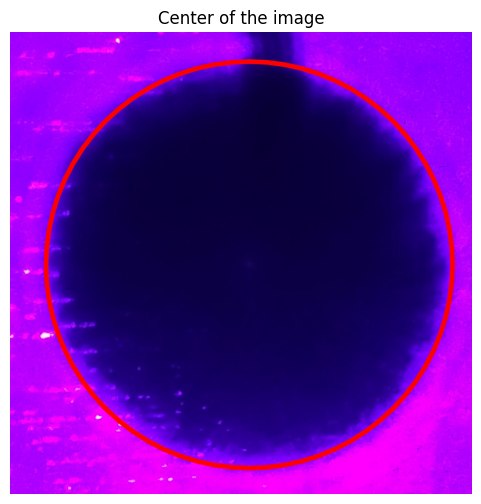

In [22]:
image_path = 'Plots and Data/B2_Files/Violet/9.png'
sphere_diameter_mm = 4.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 + 35
cy = 2634.0 - 115

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 5, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (255, 0, 0), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Violet_{sphere_diameter_mm}.pdf")
plt.show()

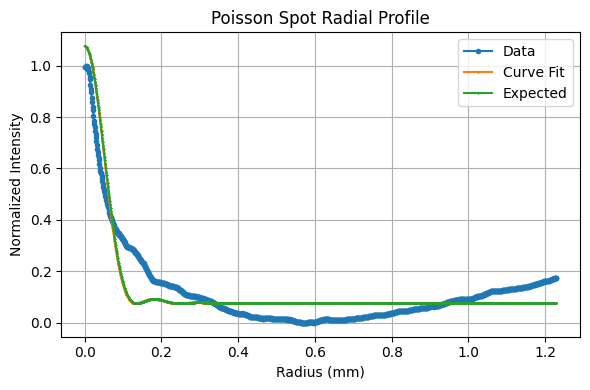

28.14493582370403 28.706297122298945 0.07546427145678307 1.9945374973004135


In [23]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)

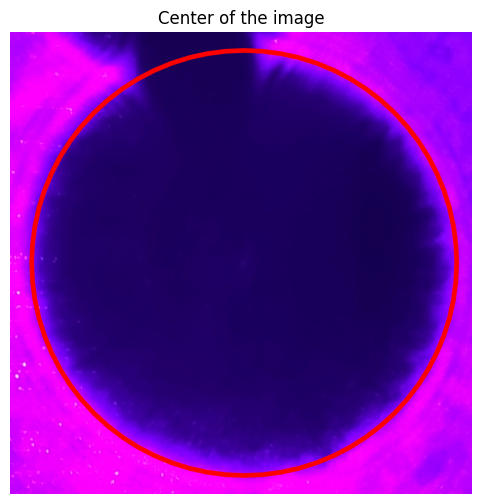

In [24]:
image_path = 'Plots and Data/B2_Files/Violet/10.png'
sphere_diameter_mm = 7.05                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 + 35 - 50 -5
cy = 2634.0 - 115 - 5 - 15

center_int = (int(cx), int(cy))
radius_int = 2300
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 5, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (255, 0, 0), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Violet_{sphere_diameter_mm}.pdf")
plt.show()

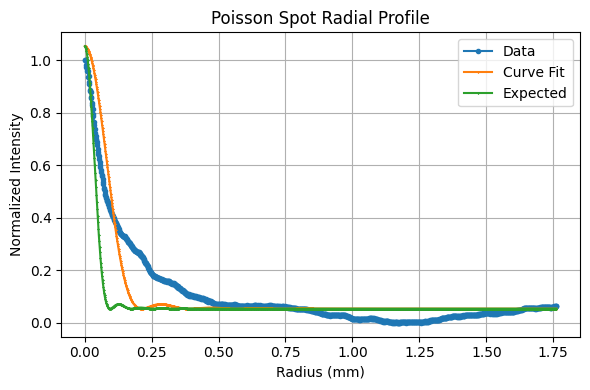

40.3296336498198 18.015267228907824 0.05426351674310114 55.329950712338494


In [25]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)

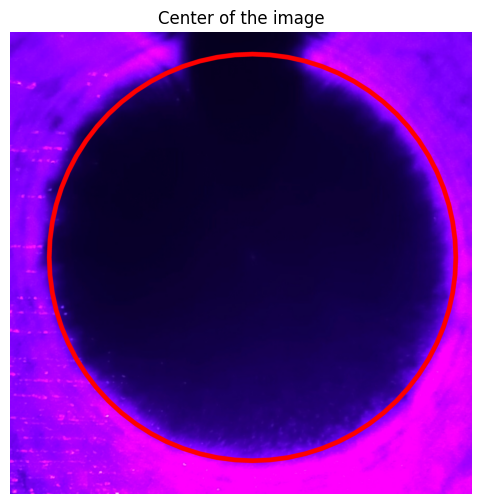

In [26]:
image_path = 'Plots and Data/B2_Files/Violet/11.png'
sphere_diameter_mm = 7.92                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 + 35 + 10 + 25
cy = 2634.0 - 215 + 20

center_int = (int(cx), int(cy))
radius_int = 2200
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 5, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (255, 0, 0), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Violet_{sphere_diameter_mm}.pdf")
plt.show()

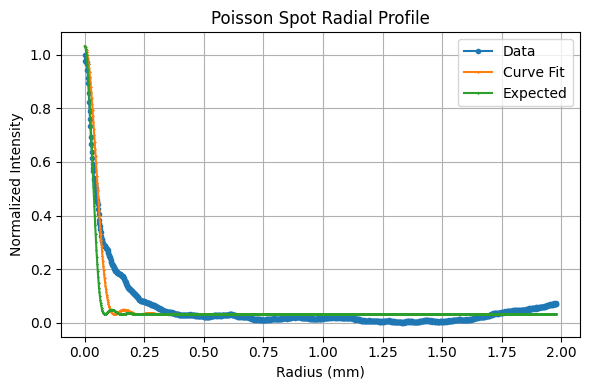

45.3064820576699 30.904040485770395 0.03185921286904924 31.788920520394562


In [27]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)

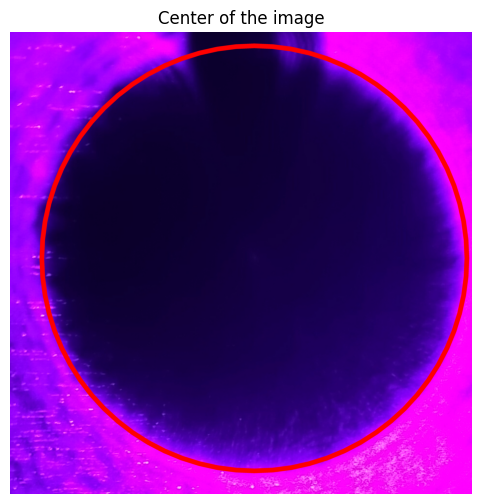

In [28]:
image_path = 'Plots and Data/B2_Files/Violet/12.png'
sphere_diameter_mm = 8.95                          
bin_width_px = 1                                  

# Load Image
img = cv2.imread(image_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {image_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap = 'gray)
           
### Find the Center
overlay = rgb_image.copy()
cx = 2554.7 + 35 + 20 + 10 + 20 + 5
cy = 2634.0 - 115 - 20 - 20 - 20 - 10

center_int = (int(cx), int(cy))
radius_int = 2300
pixel_to_mm = sphere_diameter_mm / (2*radius_int)

# cv2.circle(overlay, center_int, 5, (0, 255, 0), -1)  
cv2.circle(overlay, center_int, radius_int, (255, 0, 0), 50)  

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Center of the image')
plt.axis('off')
plt.savefig(f"Violet_{sphere_diameter_mm}.pdf")
plt.show()

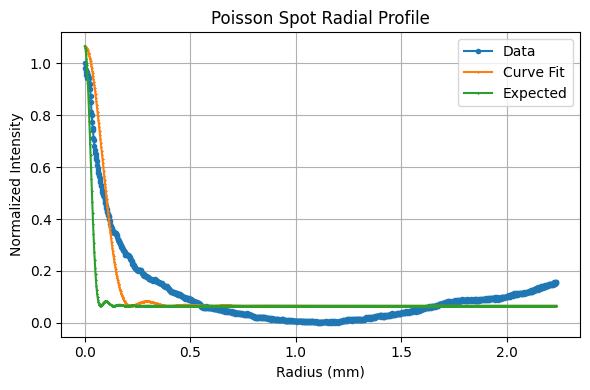

51.198612931331525 17.44450251414334 0.06566155832179484 65.92778297033122


In [29]:
D = sphere_diameter_mm*1e-3
I_data, r_data = calc_radial_profile(img, cx, cy, radius_int/2, pixel_to_mm)

# plot_intensity(I_data, r_data, radius_int, pixel_to_mm, wavelength, f"G_Int_{D * 1e3:.2f}")
p0 = [25.0, 0.0]
popt, pcov = curve_fit(airy_profile, r_data, I_data, p0)
alpha_fit, C_fit = popt
I_fit = airy_profile(r_data, alpha_fit, C_fit)
alpha_expected = (2*np.pi*D/2)/(wavelength*z)*1e-3
I_theo = airy_profile(r_data, alpha_expected, C_fit)
plot_rad(I_theo, I_fit, I_data, r_data, wavelength, D, f"G_Rad_{D * 1e3:.2f}")

print(alpha_expected, alpha_fit, C_fit, 100*abs(alpha_expected - alpha_fit)/alpha_expected)